In [130]:
import math
import torch
from torch import FloatTensor

import matplotlib.pyplot as plt

NAME_INDEX = 0
DATA_INDEX = 1
GRAD_INDEX = 2

# Data Generation

In [131]:
def generate_disc_set(nb):
    # Generates data and corresponding target
    disk_center = FloatTensor(nb, 2).fill_(0.5)
    input = FloatTensor(nb, 2).uniform_(0, 1)
    
    target = torch.norm(input.sub(disk_center), 2, 1) < math.sqrt(1/(2*math.pi))
    target = torch.eye(2).index_select(0, target.long())   # transform the 1-D target into a matrix of two 1-D vectors
                                                           # for the computation of the loss and its gradient. (see Part 2.1)
    return input, target.float()                           

# Parameter class

In [132]:
class Parameter():
    # class used to create all the parameters in the same way
    
    def __init__(self, name, tensor, gradient):
        self.name = name       # name of the parameter
        self.data = tensor     # parameter values
        self.grad = gradient   # gradient of the parameter

In [133]:
class Module ( Parameter ) :
    # base module that the following class inherits, see Part 3.1
    
    def __init__(self):
        super(Parameter, self).__init__()
        self.name = 'Base Module'  # name of the module
        self.param = []            # contains all the parameters of the Module
        
    def forward (self, * input) :
        # Computes the forward pass of the Module.
        # Need to be implemented in future class if one wants to use it.
        raise NotImplementedError
        
    def backward (self , * gradwrtoutput) :
        # Computes the backward pass of the Module for the backpropagation of the loss.
        # Need to be implemented in future class if one wants to use it.
        raise NotImplementedError
        
    def init_parameters ( self ):
        # Initialize the proper parameters for the Module.
        # Need to be implemented in future class if one wants to use it.
        raise NotImplementedError
        
    def add_parameter(self, parameter):
        # Adds the input parameter to the already existing parameters of the Module
        # Different implementation if the input parameter is:
            # - an object of class 'Parameter'(when you initialize parameters in the current module)
            # - a list of objects(when you add all the parameters of a module to another one)
        if parameter.__class__.__name__ == 'Parameter':
            self.param.append((parameter.name, parameter.data, parameter.grad))
        elif parameter.__class__.__name__ == 'list':                        
            if parameter != []:
                self.param.append(parameter)
                    
    def zero_grad( self ):
        # Reset the gradient of the parameters to 0
        for i in range(len(self.param)):             # loop on the different Module initialized in the 'self' Module
            for j in range(len(self.param[i])):      # loop on the parameters of each Module
                self.param[i][j][GRAD_INDEX][:] = 0
                    
    def optimizer (self, lr = 1e-5):
        # Optimization based on a Stochastic Gradient Descent
        # updates the parameters in regard of their gradient and the input learning rate
        for i in range(len(self.param)):             # loop on the different Module initialized in the 'self' Module
            for j in range(len(self.param[i])):      # loop on the parameters of each Module
                self.param[i][j][DATA_INDEX][:] -= lr * self.param[i][j][GRAD_INDEX][:]     # see formula (1)
                
    def parameters ( self ):
        # returns the all parameters of the Module
        return self.param

In [134]:
class MSEloss( Module ):
    # Compute the Mean Square Error between the given input and target, see Part 3.2
    # no parameters needed
    
    def __init__(self):
        super(MSEloss, self).__init__()
        self.name = 'MSEloss'
        
    def forward (self, input, target):             
        return input.sub(target).pow(2).sum()       # see formula (2)
    
    def backward (self, input, target):
        return 2*(input.sub(target))                # see formula (3)

In [135]:
class ReLU( Module ):
    # Activation functions: Rectified Linear Unit on each element of the input, see Part 3.3.1
    # no parameters needed
    
    def __init__(self):
        super(ReLU, self).__init__()
        self.name = 'ReLU'
        
    def forward(self, input):
        return input.clamp(min = 0)                 # see formula (4)
    
    def backward(self, input, dx):
        input[input <= 0] = 0                       # see formula (5)
        input[input > 0] = 1
        return input * dx

In [136]:
class Tanh( Module ):
    # Activation functions: Hyperbolic tangent of each element of the input, see Part 3.3.2
    # no parameters needed
    
    def __init__(self):
        super(Tanh, self).__init__()
        self.name = 'Tanh'
        
    def forward(self, input):
        return input.tanh()                      
    
    def backward(self, input, dx):
        return (1 - input.tanh().pow(2)) * dx       # see formula (7)

In [137]:
class Linear( Module ):
    # Linear transformation with certain weights and bias, see Part 3.4 
    
    Linear_counter = 0 # counter of the number of Linear module created in order to name properly the parameters
    
    def __init__(self, input_features, output_features, epsilon = 1e-1):
        super(Linear, self).__init__()
        self.name = 'Linear'
        Linear.Linear_counter += 1        
        self.init_parameters(input_features, output_features, epsilon)
        
    def init_parameters (self, input_features, output_features, epsilon):
        # initializes the weight parameters with a normal distribution and set their gradient to 0
        weigths_name = f'weights{self.Linear_counter}' # names the parameter accordingly to the number of linear object
        self.weights = Parameter(weigths_name, torch.Tensor(input_features, output_features),
                                 torch.Tensor(input_features, output_features))
        self.weights.data.normal_(0, epsilon)
        self.weights.grad.zero_()
        
        # initializes the bias parameters with a normal distribution and set their gradient to 0
        bias_name = f'bias{self.Linear_counter}'       # names the parameter accordingly to the number of linear object
        self.bias = Parameter(bias_name, torch.Tensor(output_features), torch.Tensor(output_features))  
        self.bias.data.normal_(0, epsilon)
        self.bias.grad.zero_()
        
        # adds the weight and bias parameters to this Module
        self.add_parameter(self.weights)
        self.add_parameter(self.bias)
        
    def forward(self, input):
        output = input.mm(self.weights.data)           # see formula (8)
        output += self.bias.data
        return output
    
    def backward(self, input, ds):
        dx = ds.mm(self.weights.data.t())              # see formula (9)
        dw = input.t().mm(ds)                          # see formula (10)
        db = ds.t().mm(torch.ones(ds.size(0), 1))      # see formula (11)
        
        self.weights.grad.add_(dw)                     # updates the gradient of the parameters with the computed values
        self.bias.grad.add_(db)
        
        return dx

In [150]:
class Sequential( Module ):
    # Sequential container of Modules object, see Part 3.5
    # The order is given by the user when creating the object of class Sequential
    
    def __init__(self, *args):
        super(Sequential, self).__init__()
        Linear.Linear_counter = 0               # resets the number of Linear for each sequential object
        self.module_nb = len(args)
        self.fc = [None] * self.module_nb       # contains the modules object in order
        self.x = [None] * (self.module_nb + 1)  # contains the input of the model 
                                                # and the intermediate results after the forward pass of each module 
        
        for id, module in enumerate(args):      # fills the list containing the modules and adds their parameters to
            self.fc[id] = module                # the sequential 'self' module
            self.init_parameters(id)
        
    def init_parameters (self, id):
        self.add_parameter(self.fc[id].parameters())
        
    def forward(self, input):                   # execute the forward pass of each module in the order given by the user
        self.x[0] = input                       # fills the list with the intermediate output of the forward
                                                # pass of each module 
        for i in range(1, self.module_nb + 1):  
            self.x[i] = self.fc[i-1].forward(self.x[i-1])
        return self.x[self.module_nb]
    
    def backward(self, dloss):                  # execute the backward pass of each module in the inverse order
        dx = [None] * (self.module_nb + 1)      # compared to the forward pass
        dx[self.module_nb] = dloss
        
        for i in range(1, self.module_nb + 1):
            j = self.module_nb - i
            dx[j] = self.fc[j].backward(self.x[j], dx[j+1])
            
        return dx

In [151]:
def train_model(model, criterion, train_input, train_target, mini_batch_size = 100, lr = 1e-5, nb_epochs = 250):
    # trains the given model 'nb_epochs' times and prints the loss for each iteration in the end
    
    sum_loss = FloatTensor(nb_epochs).zero_()                     # contains the loss after each iteration
    
    for e in range(0, nb_epochs):
        for b in range(0, train_input.size(0), mini_batch_size):  # divides the input data into batches
            
            output = model.forward(train_input.narrow(0, b, mini_batch_size))
            
            # Computation of the loss and its derivative to train the model
            loss = criterion.forward(output, train_target.narrow(0, b, mini_batch_size))
            sum_loss[e] += loss
            dloss = criterion.backward(output, train_target.narrow(0, b, mini_batch_size))
            
            # reset the gradient before the backpropagation of the loss and gradient descent
            # in order to update the parameters (learning phase)
            model.zero_grad()
            model.backward(dloss)
            model.optimizer(lr)
            
        print('{:d}: loss = {:f}'.format(e, sum_loss[e]))
    return sum_loss

In [152]:
def compute_nb_errors(model, data_input, data_target, mini_batch_size = 100):
    # computes the number of datapoint wrongly classified by the model
    
    total_nb_errors = 0
    
    for b in range(0, data_input.size(0), mini_batch_size):
        
        output = model.forward(data_input.narrow(0, b, mini_batch_size))   
        _, predicted_classes = torch.max(output, 1)                        # the predicted class is the column of the output 
                                                                           # with the greater value 
        _, target_class = torch.max(data_target, 1)                        # same goes for the target (the column with 1)
        
        for k in range(0, mini_batch_size): 
            if (target_class[b + k] != predicted_classes[k]):                # compares the prediction with the target
                total_nb_errors += 1                                       # increments when a point is wrongly classified

    return total_nb_errors

/home/dave/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.


0: loss = 621.475525
1: loss = 497.918243
2: loss = 495.190460
3: loss = 492.469116
4: loss = 488.791412
5: loss = 484.010986
6: loss = 477.414734
7: loss = 469.463531
8: loss = 459.672424
9: loss = 447.087097
10: loss = 431.646362
11: loss = 413.885529
12: loss = 393.912292
13: loss = 372.307709
14: loss = 349.829010
15: loss = 327.016174
16: loss = 304.491852
17: loss = 282.255463
18: loss = 260.530426
19: loss = 239.997635
20: loss = 221.777039
21: loss = 207.138794
22: loss = 196.653473
23: loss = 189.694092
24: loss = 185.289688
25: loss = 182.416809
26: loss = 180.477692
27: loss = 178.972870
28: loss = 177.574295
29: loss = 176.445465
30: loss = 175.340988
31: loss = 174.416351
32: loss = 173.178299
33: loss = 172.002106
34: loss = 170.499527
35: loss = 168.957031
36: loss = 167.361359
37: loss = 165.821182
38: loss = 164.313324
39: loss = 163.004379
40: loss = 161.752243
41: loss = 160.771027
42: loss = 159.804657
43: loss = 158.834274
44: loss = 158.113068
45: loss = 157.37849

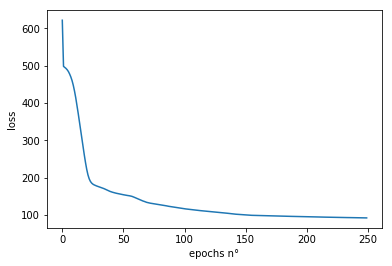

In [153]:
# Main Function

# Generation of the train and test set
train_input, train_target = generate_disc_set(1000)
test_input, test_target = generate_disc_set(1000)

mean, std = train_input.mean(), train_input.std()     # normailzation of the data
train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std);

# Training parameters
mini_batch_size = 100
nb_epochs = 250
learning_rate = 1e-3
standard_deviation = 0.1
hidden_layer = 25

# initilization of the model and criterion
model = Sequential(Linear(2, hidden_layer, standard_deviation), Tanh(), 
                   Linear(hidden_layer, hidden_layer, standard_deviation), ReLU(), 
                   Linear(hidden_layer, 2, standard_deviation))
criterion = MSEloss()

# training of the model
sum_loss = train_model(model, criterion, train_input, train_target, mini_batch_size, learning_rate, nb_epochs)

# computing of the number of error
nb_test_errors = compute_nb_errors(model, test_input, test_target, mini_batch_size)
nb_train_errors = compute_nb_errors(model, train_input, train_target, mini_batch_size)

# visualization
print('\ntrain error: {:0.2f}% ({:d}/{:d})'.format((100 * nb_train_errors) / train_input.size(0),   # number of errors on test
                                                      nb_train_errors, train_input.size(0)))
print('test error: {:0.2f}% {:d}/{:d} \n'.format((100 * nb_test_errors) / test_input.size(0),      # number of errors on test
                                                      nb_test_errors, test_input.size(0)))

print('Plot of the loss:')
plt.plot(range(nb_epochs), sum_loss.numpy())   # plots the loss at each iteration
plt.xlabel('epochs n°')
plt.ylabel('loss')
plt.show()